# Homework 5
### Dimensionality Reduction and Clustering

For the final homework, I'll be practicing some dimensionality reduction and clustering with some image data. The MNIST dataset which will be in use here is a dataset of hand-drawn numbers, from 0 to 9. I'll be going through the steps of building a classifier to identify them by training the model on a subset of the data and then testing it. Throughout this notebook, 

I'll be using the following techniques in this notebook to work on this model:

    PCA to reduce dimensionality 
    t-SNE to plot a sample of compononets 
    k-means clustering 
    Hierarchical Clustering

Buckle up!

In [1]:
!pip install seaborn

In [2]:
#The Four Packages of the Pytho-calypse
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#I Have a Plan, I Just Need [Data]!
from sklearn import datasets

In [3]:
MNIST = datasets.load_digits()
x = MNIST.data
y = MNIST.target

In [4]:
print(x.shape)

(1797, 64)


So I've got nearly 1800 images that are each 8 x 8 pixels, for a total of 64 values when flattened into a vector (side note: I used the data available from Scikit Learn so it has a slightly different number of observations and features). Let's see what a few look like:

In [5]:
def plot_digit(data):
    fig, axes = plt.subplots(1, 6, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8, 8),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))

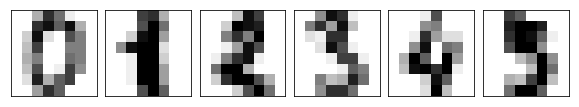

In [6]:
plot_digit(x)

## PCA

In this section, I'll go through using PCA to reduce dimensionality. Lets see how many components I could reasonably drop while preserving the most information or explanators of variance.

In [7]:
from sklearn.decomposition import PCA

Text(0.5, 1.0, 'Explained Variance by Components Preserved')

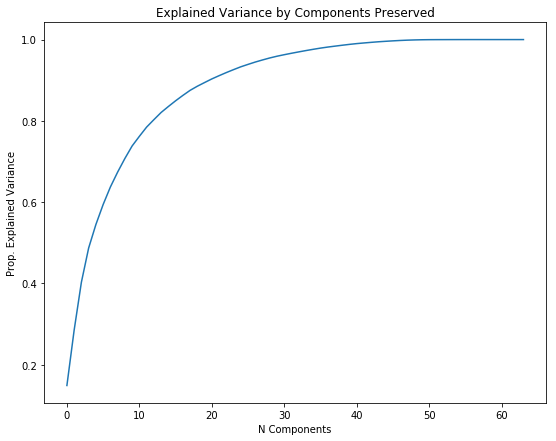

In [8]:
pca = PCA()
x_pca = pca.fit_transform(x)
cum_ratio = np.cumsum(pca.explained_variance_ratio_)

f, ax = plt.subplots(figsize=(9,7))
plt.plot(range(len(cum_ratio)), cum_ratio)
plt.ylabel('Prop. Explained Variance')
plt.xlabel('N Components')
plt.title('Explained Variance by Components Preserved')

This shows me a bit about how many components would be absolutely necessary to expalain variance in the data. Thankfully, it's not too many relative to the number of components available. One of the questions is how many components I used, or will use. To be precise, I'll refer to a benchmark of using "n" components such that that number of components explain at least 95% of the variance.

In [9]:
index_95 = np.argmax(cum_ratio >= 0.95)
print(index_95)
print(cum_ratio[index_95])

28
0.9547965245651596


**A) How many components did you use? Why?**

I'm just going to use 28 components. To be sure, any number between about 20 or 30 would probably be sufficient as that many components would explain a good amount of the variance, and any additional component added would only explain a marginally small amount more of the variance. Twenty-eight will suffice for me, but I may also allow the number of components to vary to maintain an amount that explains at least 95% of the variance.

**B) Plot the first two components. Do you notice any trends? What is the plot showing us?**

Let's have a look!

Text(0.5, 1.0, 'First Two Components')

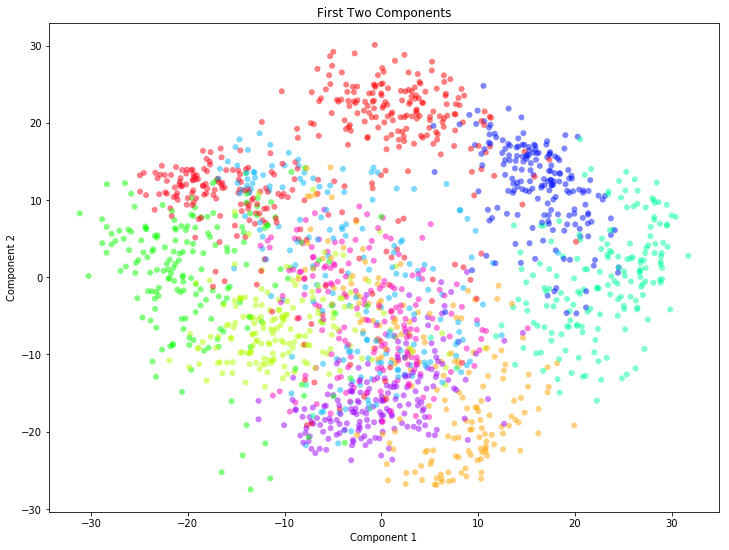

In [10]:
pca = PCA(n_components = 2)
data_pca = pca.fit_transform(x)
f, ax = plt.subplots(figsize = (12,9))
plt.scatter(data_pca[:, 0], data_pca[:, 1],
            c=y, cmap='hsv', edgecolor='none', alpha=0.5)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('First Two Components')

I used this color scheme to better illustrate the differences in digit grouping. This chart alone doesn't actually tell me which color is assigned to which digit, but some interesting patterns emerge. One digit (the one assigned to red) appears to be confused for belonging to two distinct groups and its range is very widespread. The digit assigned to blue, on the other hand, appears to be very condensed. To recap, what this chart is telling me is *the distinction between digits that can be reasonably explained within only two components*. I suspect that if I were to increase the number of components (as I showed, to around 28), the variance between these groups would decrease.

**C) Why would you use PCA? What is it doing? And what are the drawbacks?**

PCA stands for Principle Component Analysis. It's useful in that it reduces the data to its components that explain most of the variance.

Specifically, it does this by projecting the data onto the axis (or axes) with the highest variance. The idea here is that we drop the dimensions that contain the least information. The first preserved component is the axis that preserves the most variance, the second is a component orthogonal to the first that preserves the next most amount of variance, and so on. 

One drawback relates to the fact that high dimensionality is not as much a problem in modern times. We have several kinds of algorithms, such as Random Forest, that handle high dimensional data very effectively. It might also take away from the interpretability of a model because feature importances can't be used to explain what the model is using to make predictions.

**D) Plot some of the images, then compress them using PCA and plot them again. How does it look?**

I've plotted six of the images above. With prior knowledge and human intuition, it's pretty easy to guess which digit you're looking at. Below, I show how the images compare after being compressed using PCA:

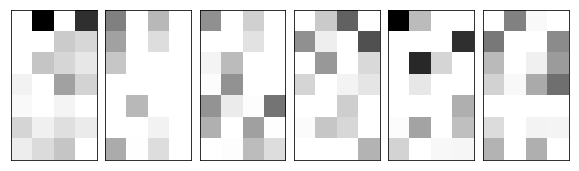

In [11]:
pca = PCA(n_components = 28)
x_pca = pca.fit_transform(x)

def plot_digit2(data):
    fig, axes = plt.subplots(1, 6, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(7, 4),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))
        
plot_digit2(x_pca)

Once compressed, the numbers become completely unintelligible and indistinguishable from one another. The boxes do, however, sort of resemble Creepers from Minecraft, but that's not helpful.

## t-SNE

This little guy is another dimensionality reduction technique, but it's mostly used for visualization and not specifically for pre-processing. Thus, reduction must be done to 2 with t-SNE so the data can be plotted onto a two-dimensional graph. In this section, I'll be visualizing the data with this dimensionality reducer to see if it can visualize variance within the data in clearer ways.

In [12]:
from sklearn.manifold import TSNE

#Reduce Dimensionality Before Feeding In
pca = PCA(n_components=50)
x_pca = pca.fit_transform(x)

rows = np.arange(1797)
np.random.shuffle(rows)
n_select = 10000

tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000, learning_rate=200)
tsne_results = tsne.fit_transform(x_pca[rows[:n_select],:])

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1797 samples in 0.003s...
[t-SNE] Computed neighbors for 1797 samples in 0.563s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1797
[t-SNE] Computed conditional probabilities for sample 1797 / 1797
[t-SNE] Mean sigma: 8.639314
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.735165
[t-SNE] KL divergence after 1000 iterations: 0.685396


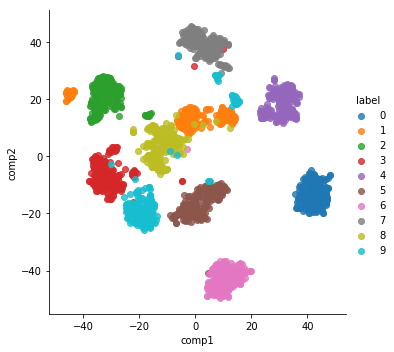

In [13]:
df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
df_tsne['label'] = y[rows[:n_select]]
sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False)

**A) How does this plot differ from your PCA plot?**

Comparing the two plots, the t-SNE plot shows the digit groups as much more compressed. In other words, it does much better at reducing them to distinct groups with only two dimensions. 

**B) How robust is it to changes in perplexity?**

I'll test this by reiterating this same model with changes in the perplexity to see what happens.

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 1797 samples in 0.003s...
[t-SNE] Computed neighbors for 1797 samples in 0.350s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1797
[t-SNE] Computed conditional probabilities for sample 1797 / 1797
[t-SNE] Mean sigma: 6.719960
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.771210
[t-SNE] KL divergence after 1000 iterations: 0.882938


Text(0.5, 1.0, 't-SNE (Perplexity = 10)')

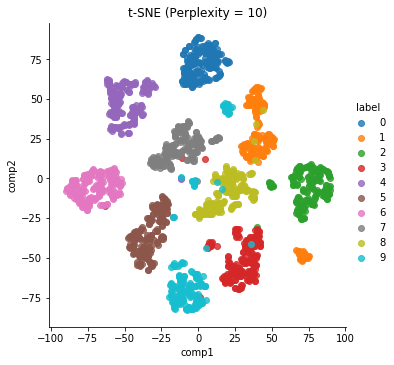

In [14]:
tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=1000, learning_rate=200)
tsne_results = tsne.fit_transform(x_pca[rows[:n_select],:])

df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
df_tsne['label'] = y[rows[:n_select]]

sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False)
plt.title('t-SNE (Perplexity = 10)')

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 1797 samples in 0.002s...
[t-SNE] Computed neighbors for 1797 samples in 0.293s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1797
[t-SNE] Computed conditional probabilities for sample 1797 / 1797
[t-SNE] Mean sigma: 5.706738
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.107826
[t-SNE] KL divergence after 1000 iterations: 0.923992


Text(0.5, 1.0, 't-SNE (Perplexity = 5)')

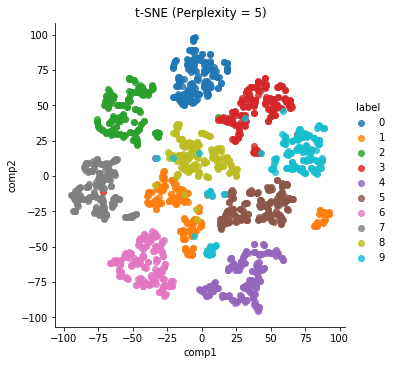

In [15]:
tsne = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=1000, learning_rate=200)
tsne_results = tsne.fit_transform(x_pca[rows[:n_select],:])

df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
df_tsne['label'] = y[rows[:n_select]]

sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False)
plt.title('t-SNE (Perplexity = 5)')

So it appears that as perplexity approaches zero, the groups become less and less clustered and some overlap between groups starts to appear. Also, it looks like decreasing perplexity has increasing marginal effect on reducing the clustering of the groups. This was evident in the low effect on clustering when moving from a perplexity of 50 to 10 compared to the relatively larger effect when moving from 10 to 5.

**C) How robust is it to a different learning rate and number of iterations?**

Again, I'll test this out with a few different trials:

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 1797 samples in 0.003s...
[t-SNE] Computed neighbors for 1797 samples in 0.308s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1797
[t-SNE] Computed conditional probabilities for sample 1797 / 1797
[t-SNE] Mean sigma: 5.706738
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.172722
[t-SNE] KL divergence after 300 iterations: 1.795616


Text(0.5, 1.0, 't-SNE (Iterations = 300)')

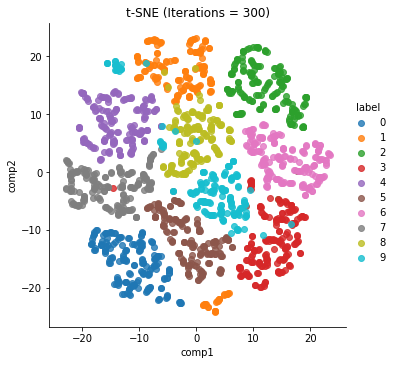

In [16]:
tsne = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=300, learning_rate=200)
tsne_results = tsne.fit_transform(x_pca[rows[:n_select],:])

df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
df_tsne['label'] = y[rows[:n_select]]

sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False)
plt.title('t-SNE (Iterations = 300)')

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 1797 samples in 0.003s...
[t-SNE] Computed neighbors for 1797 samples in 0.336s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1797
[t-SNE] Computed conditional probabilities for sample 1797 / 1797
[t-SNE] Mean sigma: 5.706738
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.975143
[t-SNE] KL divergence after 1000 iterations: 1.070673


Text(0.5, 1.0, 't-SNE (Learning Rate = 10)')

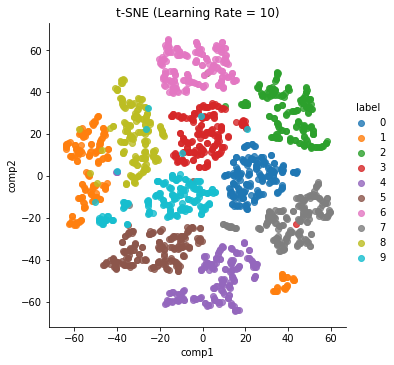

In [17]:
tsne = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=1000, learning_rate=10)
tsne_results = tsne.fit_transform(x_pca[rows[:n_select],:])

df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
df_tsne['label'] = y[rows[:n_select]]

sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False)
plt.title('t-SNE (Learning Rate = 10)')

I changed iterations from 1,000 to 300, and the learning rate from 200 to 10. Even after doing this, the clusters remain pretty distinct from each other, despite a few outliers from a few of the numbers floating across the space. It seems that, relative to its sensitivity to changes in perplexity, t-SNE is far less sensitive to changes in iterations or learning rate.

## K-Means Clustering

Next up is K-Means Clustering. 

The goal of K-Means is to discover groups of data within the data where observations within that group are similar to eachother and dissimilar to other groups. It solves this problem by finding *K distinct* clusters of data. 

Let's see how it does identifying hand-drawn digits:

In [18]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

kmeans_model = KMeans(n_clusters=10, n_init=50, n_jobs=-1)
kmeans_model.fit(x)
labels = kmeans_model.labels_
silhouette_score(x, labels, metric='euclidean')

0.18246601958265693

**A) How did you choose K?**

Thankfully, I knew beforehand that there are only 10 classes, or clusters of digits that need to be identified: one for each number from 0 to 9. Using a method to determine the best K here would be inappropriate as it would put some digits into groups that aren't practical. Were I unaware beforehand of the appropriate K, I would likely have had to use the elbow method.

**B) How did you evaluate your clustering?**

I used a simple clustering evaluation metric called the Silhouette Score. This coefficient is the mean distance between a sample and all other points in the next nearest cluster subtracted by the mean distance between a sample and all other points in the same class. It ranges from -1 to 1, with higher values meaning the clusters are denser and more distinct.

My Silhouette Score is not great, unfortunately. Things like data scaling might be able to improve this.

**C) Visualize your clusters using t-SNE**

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1797 samples in 0.004s...
[t-SNE] Computed neighbors for 1797 samples in 0.537s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1797
[t-SNE] Computed conditional probabilities for sample 1797 / 1797
[t-SNE] Mean sigma: 8.121137
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.748486
[t-SNE] KL divergence after 1000 iterations: 0.758451


Text(0.5, 1.0, 'K-Means Clustering')

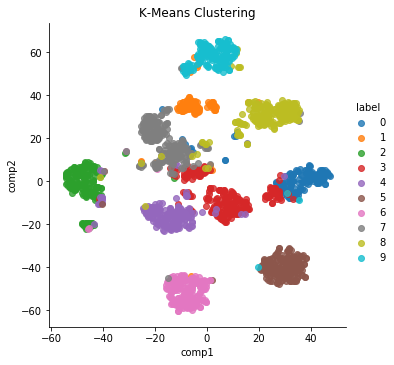

In [19]:
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1000, learning_rate=50)
tsne_results = tsne.fit_transform(x[rows[:n_select],:])

df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
df_tsne['label'] = labels[rows[:n_select]]

sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False)
plt.title('K-Means Clustering')

**D) Did you scale your data?**

I did *not* scale my data here. Scaling features can be important. This would also apply to k-means clustering because I'm taking distances between points. If I'm clustering on features that are not really comparable, scaling could be a good choice. However, scaling doesn't work well and isn't necessary when all the features in the data are the same, or measure the same thing.

**E) How robust is your clustering?**

Clustering data did pretty well at distinguishing groups! It wasn't quite as robust as PCA or t-SNE as those ones were not super sensitive to changes in things like perplexity, iterations, and learning rate.

## Hierarchical Clustering

Last but not least, I'll be looking at hierarchical clustering to solve this problem. 

This is another type of clustering that doesn't require us to provide a value for k. We will be describing bottom-up or agglomerative clustering. As with the K-Means, I'll use this to create 10 clusters within the dataset.

**A) Plot your dendrogram**

Text(0.5, 1.0, 'Complete Linkage Dendrogram')

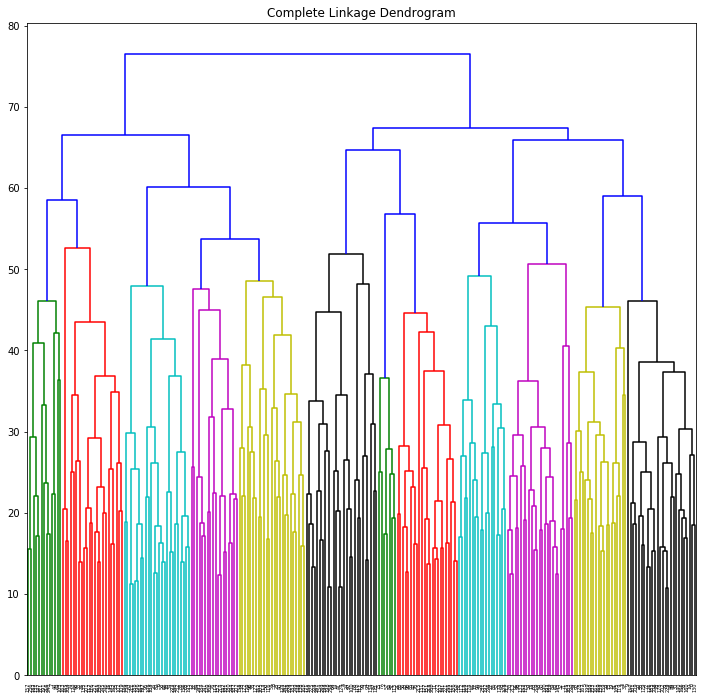

In [20]:
from scipy.cluster.hierarchy import dendrogram, linkage

#I'll start with 250 observations
x_clusters = x[:250]

Z = linkage(x_clusters, 'complete')
plt.figure(figsize=(12, 12))
_ = dendrogram(Z)
plt.title('Complete Linkage Dendrogram')

**B) How many clusters seem reasonable based on your graph?**

If I were to draw a line on the y-axis at, say, 55, it appears that the data would be grouped into about 10 or 11 clusters. That's pretty near the actual number of clusters the data actually has.

**C) How does your dendrogram change with different linkage methods?**

Good question! Here, I'll loop through some alternative methods and see how they compare:

In [21]:
def h_cluster_using(method):
    Z = linkage(x_clusters, method)
    plt.figure(figsize=(10, 10))
    print("Dendrogram Using", method ,"method \n")
    _ = dendrogram(Z)

Dendrogram Using ward method 



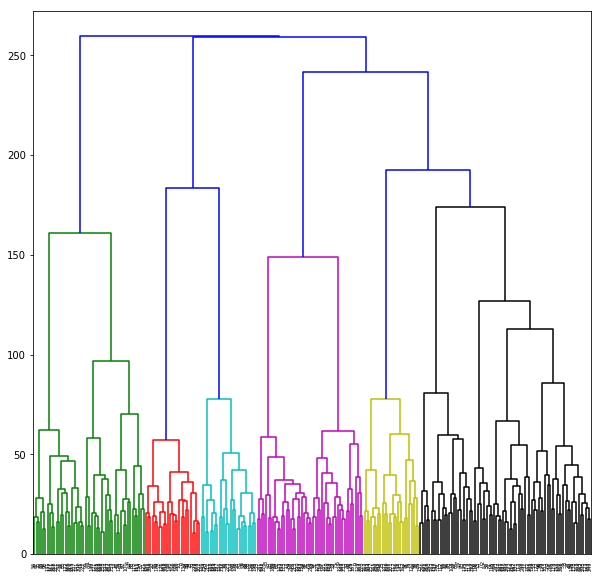

In [22]:
h_cluster_using('ward')

Dendrogram Using average method 



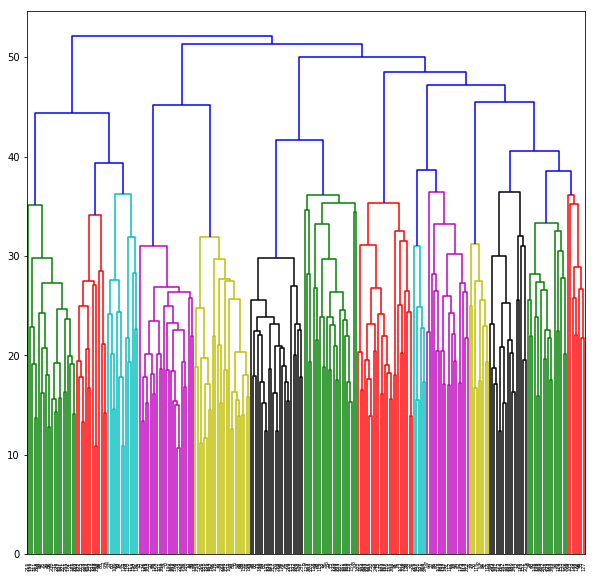

In [23]:
h_cluster_using('average')

Dendrogram Using single method 



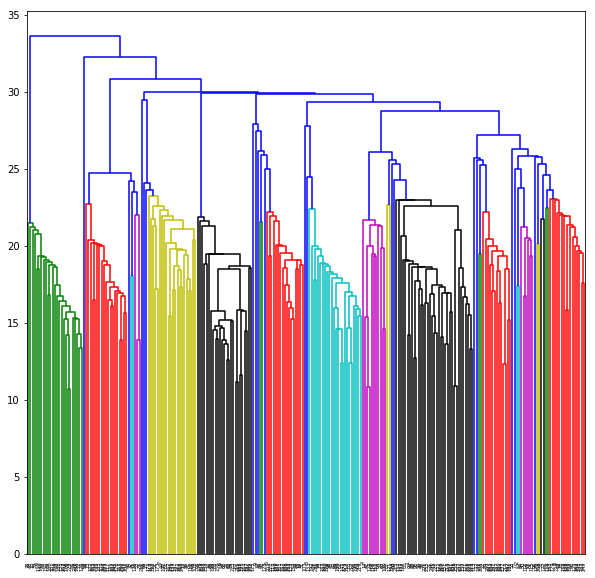

In [24]:
h_cluster_using('single')

Dendrogram Using centroid method 



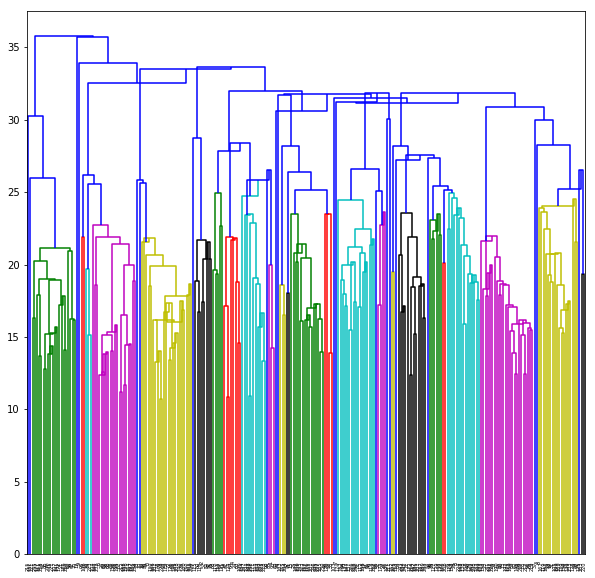

In [25]:
h_cluster_using('centroid')

I tried each of the methods available. I evaluate the different methods below:

**Ward and Average** - Ward merges the two clusters which minimze the total within-cluster variance after merging, and Average uses the average distance between points in clusters. These both did pretty well, as each of them have points where a horizontal line could go through about 9 or 10 clusters. Ward didn't find a practical number of clusters until a y-value of about 150.

**Single and Centroid** - Single uses the minimum distance between points in clusters, and centroid uses the distance between the mean vector of each cluster. These guys did alrigt but Centroid looks especially odd to evaluate as its bracket lines cross and go backwards at some points. 

## Conclusion:

I have tried with this notebook to showcase the myriad of techniques out there to make sense of data with high dimensionality. This was a simple example, but it shows the steps that an analyst would go through using high-dimensional data, at least where those dimensions are kind of measuring the same thing.

Thanks for following along!